# New York taxis trips

This homework is about New York taxi trips. Here is something from [Todd Schneider](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/):

> The New York City Taxi & Limousine Commission has released a  detailed historical dataset covering over 1 billion individual taxi trips in the city from January 2009 through December 2019. 
Taken as a whole, the detailed trip-level data is more than just a vast list of taxi pickup and drop off coordinates: it's a story of a City. 
How bad is the rush hour traffic from Midtown to JFK? 
Where does the Bridge and Tunnel crowd hang out on Saturday nights?
What time do investment bankers get to work? How has Uber changed the landscape for taxis?
The dataset addresses all of these questions and many more.

The NY taxi trips dataset has been plowed by series of distinguished data scientists.
The dataset is available from on Amazon S3 (Amazon's cloud storage service).
The link for each file has the following form:

    https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_{year}-{month}.csv

There is one CSV file for each NY taxi service (`yellow`, `green`, `fhv`) and each calendar month (replacing `{year}` and `{month}` by the desired ones).
Each file is moderately large, a few gigabytes. 
The full dataset is relatively large if it has to be handled on a laptop (several hundred gigabytes).

You will focus on the `yellow` taxi service and a pair of months, from year 2015 and from year 2018. 
Between those two years, for hire vehicles services have taken off and carved a huge marketshare.

Whatever the framework you use, `CSV` files prove hard to handle. 
After downloading the appropriate files (this takes time, but this is routine), a first step will consist in converting the csv files into a more Spark friendly format such as `parquet`.

Saving into one of those formats require decisions about bucketing, partitioning and so on. Such decisions influence performance. It is your call.
Many people have been working on this dataset, to cite but a few:


- [1 billion trips with a vengeance](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/)
- [1 billion trips with R and SQL ](http://freerangestats.info/blog/2019/12/22/nyc-taxis-sql)
- [1 billion trips with redshift](https://tech.marksblogg.com/billion-nyc-taxi-rides-redshift.html)
- [nyc-taxi](https://github.com/fmaletski/nyc-taxi-map)

Depending on your internet connection, **download the files** corresponding to **"yellow" taxis** for the years 2015 and 2018. Download **at least one month** (the same) for 2015 and 2018, if you can download all of them.

**Hint.** The 12 csv for 2015 are about 23GB in total, but the corresponding parquet file, if you can create it for all 12 months, is only about 3GB.

You **might** need the following stuff in order to work with GPS coordinates and to plot things easily.

In [1]:
!pip install geojson geopandas plotly geopy ipyleaflet

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install pyshp

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
# import the usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import os
from pathlib import Path
import sys
import timeit
import shapefile
import urllib.request
import zipfile
import random
import itertools
import math
import geopandas as gpd
import seaborn as sns
from pathlib import Path
# spark
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import asc, desc
from pyspark.sql.functions import year, dayofweek, hour
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import col
import pyspark.sql.functions as fn
from pyspark.sql.catalog import Catalog
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql import SQLContext

In [4]:
#telechargement du fichier de données de decembre 2015
data_2015_12_path = Path('yellow_tripdata_2015-12.csv')
if not data_2015_12_path.exists():
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-12.csv", "yellow_tripdata_2015-12.csv")

In [5]:
#telechargement du fichier de données de decembre 2018
data_2018_12_path = Path('yellow_tripdata_2018-12.csv')
if not data_2018_12_path.exists():
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-12.csv", "yellow_tripdata_2018-12.csv")

For this homework **we will let you decide on the tools to use** (expected for Spark) and to **find out information all by yourself** (but don't hesitate to ask questions on the `slack` channel).

In [6]:
conf = SparkConf().setAppName("Spark NY Taxis trips")
conf.set("spark.driver.memory", "4g")
sc = SparkContext(conf=conf)

spark = (SparkSession
    .builder
    .appName("Spark NY Taxis trips")
    .getOrCreate()
)

# Loading data as parquet files

We want to organize the data on a per year and per service basis. 
We want to end up with one `parquet` file for each year and each taxi service, since parquet is much better than CSV files.

**Hint.** Depending on your internet connection and your laptop, you can use only the "yellow" service and use one month of 2015 and 2018

CSV files can contain corrupted lines. You may have to work in order to perform ETL (Extract-Transform-Load) in order obtain a properly typed data frame.

You are invited to proceed as follows:

1. Try to read the CSV file without imposing a schema. 
1. Inspect the inferred schema. Do you agree with Spark's typing decision?
1. Eventually correct the schema and read again the data
1. Save the data into parquet files
1. In the rest of your work, **you will only use the parquet files you created**, not the csv files (don't forget to choose a partitioning column and a number of partitions when creating the parquet files).

**Hint.** Don't forget to ask `Spark` to use all the memory and ressources from your computer.

**Hint.** Don't foreget that you should specify a partitioning column and a number of partitions when creating the parquet files.

**Hint.** Note that the schemas of the 2015 and 2018 data are different...

**Hint.** When working on this, ask you and answer to the following questions:

1. What is the `StorageLevel` of the dataframe after reading the csv files?
1. What is the number of partitions of the dataframe? 
1. Is it possible to tune this number at loading time? 
1. Why would we want to modify the number of partitions when creating the parquet files?

## Try to read the CSV file without imposing a schema. 

In [7]:
def read_csv (input_file_name):
    df = spark.read.load(
    input_file_name,
    format="csv", 
    sep=",", 
    inferSchema="false", 
    header="true"
    )
    return df

In [8]:
#Lecture données de 2015
df_2015_12 = read_csv("yellow_tripdata_2015-12.csv")
df_2015_12.first()

Row(VendorID='2', tpep_pickup_datetime='2015-12-01 00:00:00', tpep_dropoff_datetime='2015-12-01 00:05:16', passenger_count='5', trip_distance='.96', pickup_longitude='-73.979942321777344', pickup_latitude='40.765380859375', RatecodeID='1', store_and_fwd_flag='N', dropoff_longitude='-73.96630859375', dropoff_latitude='40.763088226318359', payment_type='1', fare_amount='5.5', extra='0.5', mta_tax='0.5', tip_amount='1', tolls_amount='0', improvement_surcharge='0.3', total_amount='7.8')

In [9]:
#Lecture données de 2018
df_2018_12 = read_csv("yellow_tripdata_2018-12.csv")
df_2018_12.first()

Row(VendorID='1', tpep_pickup_datetime='2018-12-01 00:28:22', tpep_dropoff_datetime='2018-12-01 00:44:07', passenger_count='2', trip_distance='2.50', RatecodeID='1', store_and_fwd_flag='N', PULocationID='148', DOLocationID='234', payment_type='1', fare_amount='12', extra='0.5', mta_tax='0.5', tip_amount='3.95', tolls_amount='0', improvement_surcharge='0.3', total_amount='17.25')

### What is the StorageLevel of the dataframe after reading the csv files?

In [10]:
# 1. Le storageLevel par défaut est MEMORY_ONLY: Serialized 1x Replicated.
print(df_2018_12.rdd.getStorageLevel())

Serialized 1x Replicated


### What is the number of partitions of the dataframe? 
6 partitions pour 12-2018 et 14 pour 12-2015

In [11]:
print(df_2018_12.rdd.getNumPartitions())
print(df_2015_12.rdd.getNumPartitions())

6
14


### Is it possible to tune this number at loading time?
Oui en utilisant la methode .repartition(Nombre_De_Partition) lors du read

## Inspect the inferred schema. Do you agree with Spark's typing decision?
Reponse:
Pour ces deux dataframes, le schéma contient seulement des colonnes
de données de type string.
Avoir un type "général" pour les données est pratique pour les collecter mais pas pour les utiliser 
ensuite, par exemple pour utiliser les dates, les nombres.
Il faut donc proceder a une convertion de type pour mieux exploiter les données

In [12]:
#Inspection du schema de 2015
df_2015_12.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)



In [13]:
#Inspection du schema de 2018
df_2018_12.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)



On remarque :

Le schema de 2015 comporte 4 colonnes qui ne sont pas dans 2018
pickup_longitude, pickup_latitude, 
dropoff_longitude, dropoff_latitude

Le schema de 2018 comporte 2 colonnes qui ne sont pas dans 2015
PULocationID, DOLocationID

Apres plusieurs recherche on comprend que PULocationID et DOLocationID sont des id d'endroit precis dans NY. Grace a un fochier definnissant les lat et long en fonction des ID on va donc pouvoir ramener le schema de 2018 au meme que celui de 2015.
Ainsi PULocationID nous donnera les colonnes pickup_longitude, pickup_latitude.
Et DOLocationID nous donnera les colonnes dropoff_longitude, dropoff_latitude.

## Convert data_2018_12 from old schema to same schema as data_2015_12

In [14]:
#telechargement du fichier de données qui nous permettera
# d'avoir le meme schema pour les df de 2018 et 2015
shape_path = Path('shape')
if not shape_path.exists():
    urllib.request.urlretrieve("https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Original", "taxi_zones.zip")
    with zipfile.ZipFile("taxi_zones.zip","r") as zip_ref:
        zip_ref.extractall("./shape")

Lecture du fichier shape

In [15]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

gpd.read_file('shape/taxi_zones.shp').to_crs(epsg=4326).to_file("shape/taxi_zones_4326.shp")
sf_4326 = shapefile.Reader("shape/taxi_zones_4326.shp")


fields_name = [field[0] for field in sf_4326.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf_4326.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

pd_df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf_4326)\
                                        .set_index("LocationID"), on="LocationID")
sp_df_loc = spark.createDataFrame(data=pd_df_loc)
sp_df_loc = sp_df_loc\
            .withColumn('LocationID', sp_df_loc['LocationID'].cast(IntegerType()))
sp_df_loc = sp_df_loc.groupBy("LocationID").agg({'longitude':'avg', 'latitude':'avg'})
sp_df_loc = sp_df_loc.withColumnRenamed("AVG(longitude)", "longitude")\
            .withColumnRenamed("AVG(latitude)", "latitude")
PULocationID = sp_df_loc.selectExpr('LocationID as PULocationID','longitude as pickup_longitude','latitude as pickup_latitude')
DOLocationID = sp_df_loc.selectExpr('LocationID as DOLocationID','longitude as dropoff_longitude','latitude as dropoff_latitude')

In [16]:
from pyspark.sql.functions import round, col
spark.createDataFrame(data=pd_df_loc).select("*", round(col('longitude'),3),round(col('latitude'),3))\
.select('LocationID','round(longitude, 3)','round(latitude, 3)').show()

+----------+-------------------+------------------+
|LocationID|round(longitude, 3)|round(latitude, 3)|
+----------+-------------------+------------------+
|         1|            -74.172|            40.689|
|         2|            -73.822|            40.611|
|         3|            -73.845|            40.866|
|         4|            -73.978|            40.724|
|         5|            -74.188|            40.551|
|         6|            -74.073|            40.599|
|         7|             -73.92|            40.761|
|         8|            -73.923|            40.779|
|         9|            -73.787|            40.754|
|        10|            -73.789|            40.678|
|        11|            -74.008|            40.604|
|        12|            -74.016|            40.702|
|        13|            -74.016|            40.712|
|        14|            -74.029|            40.624|
|        15|            -73.785|            40.785|
|        16|            -73.775|            40.761|
|        17|

In [17]:
sp_df_loc.show(2)

+----------+------------------+------------------+
|LocationID|          latitude|         longitude|
+----------+------------------+------------------+
|       148|40.719101661499906|-73.99066416299985|
|       243| 40.85863655093581| -73.9357980222621|
+----------+------------------+------------------+
only showing top 2 rows



In [18]:
PULocationID.printSchema()
DOLocationID.printSchema()

root
 |-- PULocationID: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)

root
 |-- DOLocationID: integer (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



In [19]:
#Preparation de la jointure des deux df
df_2018_12 = df_2018_12\
            .withColumn('PULocationID', df_2018_12['PULocationID'].cast(IntegerType()))\
            .withColumn('DOLocationID', df_2018_12['DOLocationID'].cast(IntegerType()))

In [20]:
#Affichage du nombre de ligne pour garder un oeil sur la perte de donnée apres jointure
print(df_2018_12.count())

8173231


In [21]:
#jointure
df_2018_12 = df_2018_12.join(PULocationID, on=['PULocationID'], how='inner')
df_2018_12 = df_2018_12.join(DOLocationID, on=['DOLocationID'], how='inner')
df_2018_12 = df_2018_12.select('VendorID','tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count','trip_distance','pickup_longitude','pickup_latitude','RateCodeID','store_and_fwd_flag','dropoff_longitude','dropoff_latitude','payment_type','fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount')

In [22]:
print(df_2018_12.count())

7984234


Conclusion:
On a donc perdu quelque données apres la jointure.
Apres recherche, on explique cela par le fait que dans le fichier data_2018 nous avons des PULocationID et DOLocationID qui ont pour valeur 264;265.
Ses ID ne sont pas present dans le fichier shape pris depuis le site NYC open data.
Par conséquent ses lignes la sont perdu lors de la jointure.

In [23]:
#Inspection du schema de 2018
df_2018_12.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)



## Eventually correct the schema and read again the data
Nous avons donc a present deux fichier de données de schema identique dont nous allons maintenant changer les type afin de mieux pouvoir exploiter les données par la suite.

In [24]:
def type_transformer(df):
    df = df\
    .withColumn('VendorID', df['VendorID'].cast(IntegerType()))\
    .withColumn('tpep_pickup_datetime', df['tpep_pickup_datetime'].cast(TimestampType()))\
    .withColumn('tpep_dropoff_datetime', df['tpep_dropoff_datetime'].cast(TimestampType()))\
    .withColumn('passenger_count', df['passenger_count'].cast(IntegerType()))\
    .withColumn('trip_distance', df['trip_distance'].cast(DoubleType()))\
    .withColumn('pickup_longitude', df['pickup_longitude'].cast(DoubleType()))\
    .withColumn('pickup_latitude', df['pickup_latitude'].cast(DoubleType()))\
    .withColumn('RateCodeID', df['RateCodeID'].cast(IntegerType()))\
    .withColumn('dropoff_longitude', df['dropoff_longitude'].cast(DoubleType()))\
    .withColumn('dropoff_latitude', df['dropoff_latitude'].cast(DoubleType()))\
    .withColumn('payment_type', df['payment_type'].cast(IntegerType()))\
    .withColumn('fare_amount', df['fare_amount'].cast(DoubleType()))\
    .withColumn('extra', df['extra'].cast(DoubleType()))\
    .withColumn('mta_tax', df['mta_tax'].cast(DoubleType()))\
    .withColumn('tip_amount', df['tip_amount'].cast(DoubleType()))\
    .withColumn('tolls_amount', df['tolls_amount'].cast(DoubleType()))\
    .withColumn('improvement_surcharge', df['improvement_surcharge'].cast(DoubleType()))\
    .withColumn('total_amount', df['total_amount'].cast(DoubleType()))
    return df

def year_transformer(df):
    year_col = year(col('tpep_pickup_datetime'))
    df = df.withColumn('year', year_col)
    return df

In [25]:
transformers = [
    type_transformer,
    year_transformer
]

In [26]:
#transformation des types des données de 2015 et 2018
for transformer in transformers:
    df_2015_12 = transformer(df_2015_12)
    df_2018_12 = transformer(df_2018_12)

df_2015_12.printSchema()
df_2018_12.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- year: integer (nullable = true)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timesta

## Save the data into parquet files

In [27]:
df_records = df_2015_12.union(df_2018_12)

Nos données que nous allons etudier sont donc maintenant dans le dataframes df_records.
Nous allons donc maintenant creer notre fichier parquet avec un partitionby year afin de pouvoir exploiter ensuite les données selon l'année pour facilement.

### Why would we want to modify the number of partitions when creating the parquet files?
On voudrait modifier le nombre de partitions par défaut (la valeur par défaut de spark.sql.shuffle.partitions est 200) pour l'adapter au dataframe : si c'est un "petit" dataframe, 200 c'est trop et si c'est un grand dataframe

In [29]:
parquet_path = Path('parquets/data_2015_2018_12.parquet')
if not parquet_path.exists():
    df_records.write.partitionBy("year").parquet('parquets/data_2015_2018_12.parquet')

# Investigate (at least) one month of data in 2015

From now on, you will be using **the parquet files you created for 2015**.

We shall visualize several features of taxi traffic during one calendar month
in 2015 and the same calendar month in 2018.

**Hint.** In order to build appealing graphics, you may stick to `matplotlib + seaborn`, you can use also
`plotly`, which is used a lot to build interactive graphics, but you can use whatever you want.

In [30]:
df = spark.read.parquet('parquets/data_2015_2018_12.parquet')
df2015 = spark.read.parquet("parquets/data_2015_2018_12.parquet/year=2015")
df2018 = spark.read.parquet("parquets/data_2015_2018_12.parquet/year=2018")

The following longitudes and lattitudes encompass Newark and JFK airports, Northern Manhattan and Verazzano bridge.

In [31]:
long_min = -74.10
long_max = -73.70
lat_min = 40.58
lat_max = 40.90

1. Using these boundaries, **filter the 2015 data** (using pickup and dropoff longitude and latitude) and count the number of trips for each value of `passenger_count` and make a plot of that.

In [32]:
newdf15 = df2015.filter(df2015.pickup_longitude.between(long_min, long_max) \
                      & df2015.pickup_latitude.between(lat_min, lat_max) \
                      & df2015.dropoff_longitude.between(long_min, long_max) \
                      & df2015.dropoff_latitude.between(lat_min, lat_max))

In [33]:
data = newdf15.groupBy('passenger_count')\
              .agg(fn.count('passenger_count') \
              .alias('count_pc'))\
                .sort(asc('passenger_count'))
data.show()

+---------------+--------+
|passenger_count|count_pc|
+---------------+--------+
|              0|     395|
|              1| 7846583|
|              2| 1661766|
|              3|  489298|
|              4|  254084|
|              5|  607410|
|              6|  374946|
|              7|      18|
|              8|       7|
|              9|       7|
+---------------+--------+



<BarContainer object of 10 artists>

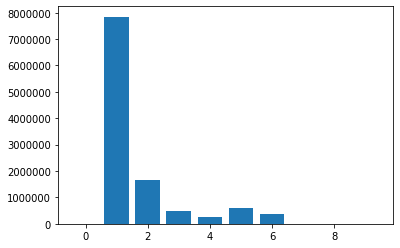

In [34]:
import matplotlib.pyplot as plt

x_array = [row.passenger_count for row in data.select("passenger_count").collect()]
y_array = [row.count_pc for row in data.select("count_pc").collect()]
plt.bar(x_array, height=y_array)

Trips with $0$ or larger than $7$ passengers are pretty rare.
We suspect these to be outliers. 
We need to explore these trips further in order order to understand what might be wrong
with them

### What's special with trips with zero passengers?

In [35]:
df2015_0 = df2015.filter(df2015['passenger_count']==0)

In [36]:
df2015_0.select('tpep_pickup_datetime','tpep_dropoff_datetime','trip_distance','total_amount').show(100)

+--------------------+---------------------+-------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|total_amount|
+--------------------+---------------------+-------------+------------+
| 2015-12-23 14:19:57|  2015-12-23 14:21:30|          0.1|         0.3|
| 2015-12-23 14:54:17|  2015-12-23 14:54:17|          0.0|        70.3|
| 2015-12-23 15:40:03|  2015-12-23 15:44:20|          0.0|        11.8|
| 2015-12-23 15:57:11|  2015-12-23 15:57:11|          0.0|         9.0|
| 2015-12-23 16:21:11|  2015-12-23 16:21:23|          0.0|        50.8|
| 2015-12-26 20:57:58|  2015-12-26 21:11:29|          1.8|        11.8|
| 2015-12-23 20:44:02|  2015-12-23 20:44:05|          0.0|         8.3|
| 2015-12-23 20:50:20|  2015-12-23 20:50:42|          0.0|         0.3|
| 2015-12-23 22:54:24|  2015-12-23 22:55:18|          0.0|        0.31|
| 2015-12-23 23:31:45|  2015-12-23 23:55:17|        12.42|       100.8|
| 2015-12-23 23:44:46|  2015-12-23 23:46:24|          0.0|      

Apres analyse de ses données on peux penser que les trajets avec zero passager peuvent etre:
    - Taxis qui transporte des colis
    - Taxis ayant oublier de mettre le nombre de personne
    - Trajet annuler au bout de quelque minutes
    -...
Quoi qu'il en soit ses données ne sont donc pas pertinantes car nous avons pas de controle dessus.
Elles seront enlever dans la partie 4

### What's special with trips with more than $6$ passengers?

In [37]:
df2015_greater_than_6 = df2015.filter(df2015['passenger_count']>6)
df2015_greater_than_6.select('tpep_pickup_datetime','tpep_dropoff_datetime','trip_distance','total_amount').show(10)

+--------------------+---------------------+-------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|total_amount|
+--------------------+---------------------+-------------+------------+
| 2015-12-23 13:44:04|  2015-12-24 00:00:00|          0.0|      115.91|
| 2015-12-23 23:46:27|  2015-12-24 00:23:41|        19.64|      103.56|
| 2015-12-24 09:13:55|  2015-12-24 09:40:54|          0.0|        70.8|
| 2015-12-30 08:58:59|  2015-12-31 08:27:13|         0.01|        80.5|
| 2015-12-30 22:38:05|  2015-12-30 22:38:24|          0.0|        70.3|
| 2015-12-13 08:29:16|  2015-12-13 08:54:36|         17.2|        93.0|
| 2015-12-26 17:38:04|  2015-12-26 17:46:39|          1.1|         8.3|
| 2015-12-07 16:46:41|  2015-12-07 18:39:19|         21.2|      209.19|
| 2015-12-25 00:34:21|  2015-12-25 00:34:23|          0.0|         8.3|
| 2015-12-25 05:14:53|  2015-12-25 05:14:57|          0.0|        80.8|
+--------------------+---------------------+-------------+------

Apres analyse de ses données on peux penser que les trajets avec plus de 6 passagers peuvent etre:
    - Taxis Limousines
    - Taxis Van
Quoi qu'il en soit ses données sont rares, elle ne represente pas la majorité des trajets
Elles seront enlever dans la partie 4

### What is the largest distance travelled during this month? Is it the first taxi on the moon?

In [38]:
df2015.sort(desc('trip_distance'))\
.select('tpep_pickup_datetime','tpep_dropoff_datetime','trip_distance','passenger_count','total_amount')\
.show(1)

+--------------------+---------------------+-------------+---------------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|passenger_count|total_amount|
+--------------------+---------------------+-------------+---------------+------------+
| 2015-12-05 02:07:42|  2015-12-05 12:48:17|    1.52004E7|              1|        25.3|
+--------------------+---------------------+-------------+---------------+------------+
only showing top 1 row



<p>1.52004E7 = 15200400miles = ~24462672km</p>
<p>distance terre-lune = 384400km</p>
<p>24462672/384400 = ~63</p>
Non seulement c'est peut etre le premier taxi a voyager sur la lune mais en plus il en a certainement profiter pour faire ~31 aller retour :)

### Plot the distribution of the `trip_distance` (using an histogram for instance) during year 2105. Focus on trips with non-zero trip distance and trip distance less than 30 miles.

Let's look at what Spark does for these computations

### Use the `explain` method or have a look at the [Spark UI](http://localhost:4040/SQL/) to analyze the job. You should be able to assess 
    - Parsed Logical Plan
    - Analyzed Logical Plan
    - Optimized Logical Plan
    - Physical Plan

In [39]:
#Obtenir les 4 types de plans (parsed logical, analyzed logical, optimized logicial, physical)
df2015.explain(True)

== Parsed Logical Plan ==
Relation[VendorID#1276,tpep_pickup_datetime#1277,tpep_dropoff_datetime#1278,passenger_count#1279,trip_distance#1280,pickup_longitude#1281,pickup_latitude#1282,RateCodeID#1283,store_and_fwd_flag#1284,dropoff_longitude#1285,dropoff_latitude#1286,payment_type#1287,fare_amount#1288,extra#1289,mta_tax#1290,tip_amount#1291,tolls_amount#1292,improvement_surcharge#1293,total_amount#1294] parquet

== Analyzed Logical Plan ==
VendorID: int, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: int, trip_distance: double, pickup_longitude: double, pickup_latitude: double, RateCodeID: int, store_and_fwd_flag: string, dropoff_longitude: double, dropoff_latitude: double, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double
Relation[VendorID#1276,tpep_pickup_datetime#1277,tpep_dropoff_datetime#1278,passenger_count#1279,trip_distance#1

### Do the Analyzed Logical Plan and Optimized Logical Plan differ? Spot the differences if any. How would a RDBMS proceed with such a query?

Il y a une différence entre le plan logique Analyzed (analysé par Catalyst) et le plan logique Optimized : dans le plan analyzed, il y a la relation (nom de la colonne suivi de # et d'un nombre) et chaque colonne et son type dans df2015 alors que df2018 contient seulement la relation. Pour passer d'un plan logique parsé en un plan Analyzed, Catalyst effectue une résolution des types et une résolution des noms dans la requête. Pour passer d'un plan logique Analyzed en un plan logique Optimized, l'optimisateur Catalyst applique des règles d'optimisation, qui modifient le TreeNode dans Spark SQL.

### How does the physical plan differ from the Optimized Logical Plan? What are the keywords you would not expects in a RDBMS? What is their meaning? 

Dans le plan physique, en plus de la relation du type de chaque colonne du df2015, il y a également une indication "FileScan" sur l'exécution de la requête, et il y a des informations générales : le format de fichier, sa localisation dans l'ordinateur, la liste des filtres PartitionFilter, la liste des filtres PushedFilters etc. Le plan physique est celui qui exécuté pour produire le résultat de la requête SQL.

### Inspect the stages on [Spark UI](http://localhost:4040/stages/stage). How many *stages* are necessary to complete the Spark job? What are the roles of `HashAggregate` and `Exchange hashpartitioning`?

Pour compléter le Spark job, il faut 7 stages. HashAggregate et Exchange hashpartitioning sont des opérations de plan d'exécution.

L'opération HashAggregate utilise une table de hachage temporaire pour grouper les enregistrements. Cette opération ne requiert pas de données pré-triées. Elle utilise une grande quantité de mémoire pour matérialiser le résultat intermédiaire (sans pipeline). La sortie n'est pas triée.

L'Exchange signfie échange de shuffle entre les jobs. Le hashpartitioning est une technique de partitionnement dans lequel une clef de hachage est utilisée pour distribuer les lignes de manière homogène à travers les différentes partitions.

### Does the physical plan perform `shuffle` operations? If yes how many?

### What are tasks with respect to stages (in Spark language)? How many tasks are your stages made of?

Un stage est une séquence de tâches qui peuvent être exécutées ensemble, sans shuffle. Une tâche est une opération (map ou filter) qui se produit dans une partition RDD spécifique. Mes stages sont tous constitués d'une seule task.

Now, compute the following and produce relevant plots:

### Break down the trip distance distribution for each day of week

In [40]:
def day_transformer(df):
    day_col = dayofweek(col('tpep_pickup_datetime'))
    df = df.withColumn('day', day_col)
    return df

In [41]:
df2015_by_day = day_transformer(df2015)
df2015_by_day = df2015_by_day.select('day', 'trip_distance')
df2015_by_day = df2015_by_day.groupBy("day").agg({'trip_distance':'avg'})
df2015_by_day.show()

+---+------------------+
|day|avg(trip_distance)|
+---+------------------+
|  1|3.1934650208294815|
|  6| 3.021697094749593|
|  3| 3.855749370094042|
|  5| 3.789436287014272|
|  4|2.9455406114047977|
|  7| 17.43444996509521|
|  2|3.0739559960709952|
+---+------------------+



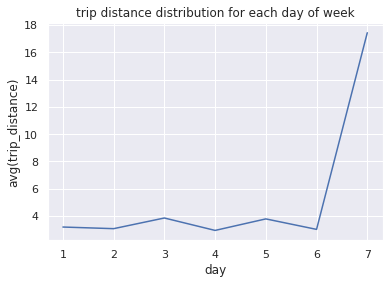

In [42]:
pd_df2015_by_day = df2015_by_day.toPandas()
sns.set()
q = sns.lineplot(x = "day",
                 y = "avg(trip_distance)",
                 data = pd_df2015_by_day)

q.set_title("trip distance distribution for each day of week")
plt.show(q)

### Count the number of distinct pickup location
Apres recherche on a que :
<p>Si 2 position long/lat differe a 0.1 pres alors elle sont a environ 10km de distance
(ex:une ville/un quartier difference)</p>
<p>Si 2 position long/lat differe a 0.01 pres alors elle sont a environ 1km de distance (ex:quelque patés de maison de difference)</p>
<p>Si 2 position long/lat differe a 0.001 pres alors elle sont a environ 100m de distance (ex:une rue de difference)</p>

On va utiliser ses mesures pour definir ce qu'est 2 position distincts

source : https://en.wikipedia.org/wiki/Decimal_degrees

In [43]:
#Arrondi a 0.1 pres
df2015.select("*", round(col('pickup_longitude'),1),round(col('pickup_latitude'),1))\
            .select('round(pickup_longitude, 1)','round(pickup_latitude, 1)')\
            .distinct().count()

340

In [44]:
#Arrondi a 0.01 pres
df2015.select("*", round(col('pickup_longitude'),2),round(col('pickup_latitude'),2))\
            .select('round(pickup_longitude, 2)','round(pickup_latitude, 2)')\
            .distinct().count()

2680

In [45]:
#Arrondi a 0.001 pres
df2015.select("*", round(col('pickup_longitude'),3),round(col('pickup_latitude'),3))\
            .select('round(pickup_longitude, 3)','round(pickup_latitude, 3)')\
            .distinct().count()

28107

### Compute and display tips and profits as a function of the pickup location

# Investigate one month of trips data in 2015 and 2018

 Consider one month of trips data from `yellow` taxis for each year

### Filter and cache/persist the result

In [46]:
diff_secs_col = col("tpep_dropoff_datetime").cast("long") - col("tpep_pickup_datetime").cast("long")


new_df = df.filter(df['passenger_count'].between(1,6))\
.drop('VendorID','passenger_count','RateCodeID','store_and_fwd_flag','extra','mta_tax','tolls_amount','improvement_surcharge')\
.withColumn('hour', hour(col('tpep_pickup_datetime')))\
.withColumn('day', dayofweek(col('tpep_pickup_datetime')))\
.withColumn( "trip_duration", diff_secs_col/ 60 )\
.cache()

## Assessing seasonalities and looking at time series

Compute and plot the following time series indexed by day of the week and hour of day:

### The number of pickups

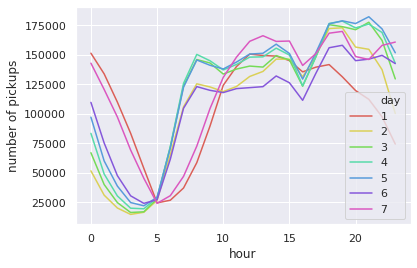

In [47]:
pd_data_by_day_hour = new_df.groupBy("day","hour").agg({'trip_distance':'count'}).toPandas()
palette = sns.color_palette("hls", 7)

fig = sns.lineplot(x='hour', 
             y='count(trip_distance)',
             hue='day',
            palette=palette,
             data=pd_data_by_day_hour)

ax = plt.ylabel("number of pickups")


### The average fare

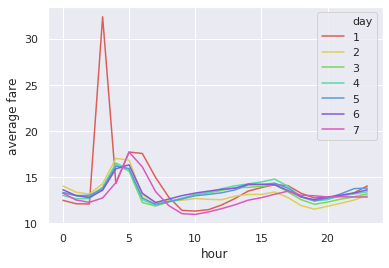

In [48]:
pd_data_by_day_hour = new_df.groupBy("day","hour").agg({'fare_amount':'avg'}).toPandas()
palette = sns.color_palette("hls", 7)

fig = sns.lineplot(x='hour', 
             y='avg(fare_amount)',
             hue='day',
            palette=palette,
             data=pd_data_by_day_hour)

ax = plt.ylabel("average fare")

### The average trip duration

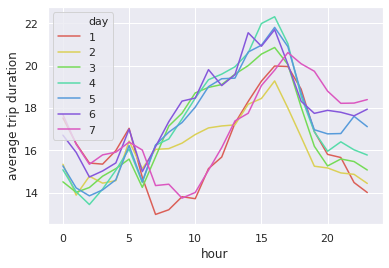

In [49]:
pd_data_by_day_hour = new_df.groupBy("day","hour").agg({'trip_duration':'avg'}).toPandas()
palette = sns.color_palette("hls", 7)

fig = sns.lineplot(x='hour', 
             y='avg(trip_duration)',
             hue='day',
            palette=palette,
             data=pd_data_by_day_hour)

ax = plt.ylabel("average trip duration")

### Plot the average number of ongoing trips

## Rides to the airports

In order to find the longitude and lattitude of JFK and Newark airport as well as the longitude and magnitudes 
of Manhattan, you can use a service like [geojson.io](http://geojson.io/).
Plot the following time series, indexed the day of the week and hour of the day

Nous allons nous ici utiliser notre fichier shape contenant les données des endroits de NY.

In [50]:
array = ['Newark Airport', 'JFK Airport']
airport = pd_df_loc.loc[pd_df_loc['zone'].isin(array)]
array = ['Midtown Center', 'Midtown East', 'Midtown North', 'Midtown South']
midtown = pd_df_loc.loc[pd_df_loc['zone'].isin(array)]

In [51]:
airport[['zone', 'longitude', 'latitude']].round(2)

,zone,longitude,latitude
0,Newark Airport,-74.17,40.69
131,JFK Airport,-73.79,40.64


In [52]:
midtown[['zone', 'longitude', 'latitude']].round(2)

,zone,longitude,latitude
160,Midtown Center,-73.98,40.76
161,Midtown East,-73.97,40.76
162,Midtown North,-73.98,40.76
163,Midtown South,-73.99,40.75


In [53]:
spark.createDataFrame(data=pd_df_loc)

DataFrame[OBJECTID: bigint, Shape_Leng: double, Shape_Area: double, zone: string, LocationID: bigint, borough: string, longitude: double, latitude: double]

###  Median duration of taxi trip leaving Midtown (Southern Manhattan) headed for JFK Airport

In [54]:
from pyspark.sql.functions import row_number, monotonically_increasing_id
w = Window.orderBy("trip_duration")

midtown_to_jfk = new_df.filter(new_df['pickup_longitude'].between(-74,-73.96) \
                               & new_df['pickup_latitude'].between(40.74,40.77)\
                               & new_df['dropoff_longitude'].between(-73.80,-73.78)\
                               & new_df['dropoff_latitude'].between(40.63,40.65))\
                .select('trip_duration').sort(asc('trip_duration'))\
                .withColumn("index", row_number().over(w))

In [55]:
nb = midtown_to_jfk.count()

In [56]:
midtown_to_jfk.where(col("index") == int(nb/2)).drop('index').selectExpr('trip_duration as Median').show()

+-----------------+
|           Median|
+-----------------+
|45.46666666666667|
+-----------------+



### Median taxi duration of trip leaving from JFK Airport to Midtown (Southern Manhattan)

In [57]:
jfk_to_midtown = new_df.filter(new_df['dropoff_longitude'].between(-74,-73.96) \
                               & new_df['dropoff_latitude'].between(40.74,40.77)\
                               & new_df['pickup_longitude'].between(-73.80,-73.78)\
                               & new_df['pickup_latitude'].between(40.63,40.65))\
                .select('trip_duration').sort(asc('trip_duration'))\
                .withColumn("index", row_number().over(w))

In [58]:
nb2 = jfk_to_midtown.count()

In [59]:
jfk_to_midtown.where(col("index") == int(nb2/2)).drop('index').selectExpr('trip_duration as Median').show()

+------+
|Median|
+------+
|  52.4|
+------+



## Geographic information

For this, you will need to find tools to display maps and to build choropeth maps.
We let you look and find relevant tools to do this.

### Build a heatmap where color is a function of
1. number of `pickups`
2. number of `dropoffs`
3. number of `pickups` with dropoff at some airport (JFK, LaGuardia, Newark)

### Build a choropeth map where color is a function of
1. number of pickups in the area
1. ratio of number of payments by card/number of cash payments for pickups in the area
2. ratio of total fare/trip duration for dropoff in the area

### Build an interactive chorophet with a slider allowing the user to select an `hour of day` and where the color is a function of
1. average number of dropoffs in the area during that hour the day
2. average ratio of tip over total fare amount for pickups in the area at given hour of the day